# Simple ResNet Implementation (TensorFlow)



## Residual Block

<center><img src="./residual_block.png" width="600" height="250"></center>

- Left block: a building block of ResNet18, ResNet34
- Right block: **Bottleneck block** of ResNet50, ResNet101, ResNet 152
    - Call it 'bottleneck' because the number of channels in the feature map decreases and again increases.
    - The change of channels: 256 $\to$ 64 $\to$ 256
    - Deeper with more non-linearity

### Bottleneck blocks are necessary in deeper models!

Comparison of numbers of parameters
- $(3 \times 3 \times 64) \times 64 + (3 \times 3 \times 64) \times 64 = 73,728$ params in basic blocks
- $(1 \times 1 \times 256) \times 64 + (3 \times 3 \times 64) \times 64 + (1 \times 1 \times 64) \times 256 = 69,632$ params in bottleneck blocks



## Construct Residual Blocks

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### Basic Block

In [2]:
def make_basic_residual(num_filters, stride):
    def f(x):
        x = Conv2D(filters=num_filters,
                   kernel_size=(3,3),
                   strides=stride, padding='same',
                   activation=None,
                   use_bias=False, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = relu(x)

        x = Conv2D(filters=num_filters,
                   kernel_size=(3,3),
                   strides=1, padding='same',
                   use_bias=False, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)

        return x
    return f

def BasicBlock(num_filters, stride):
    def f(x):
        y = make_basic_residual(num_filters, stride)(x)

        if stride!=1 or x.shape[-1] != num_filters:
            x = Conv2D(filters=num_filters,
                       kernel_size=(1,1),
                       strides=stride, padding='same',
                       activation=None,
                       use_bias=True, kernel_initializer='he_normal')(x)
        return relu(add([x,y]))
    return f

### Bottleneck Block

In [3]:
def make_bottleneck_residual(num_filters, stride):
    def f(x):
        x = Conv2D(filters=num_filters//4,
                   kernel_size=(1,1),
                   strides=stride, padding='same',
                   activation=None,
                   use_bias=False, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = relu(x)
        x = Conv2D(filters=num_filters//4,
                   kernel_size=(3,3),
                   strides=1, padding='same',
                   activation=None,
                   use_bias=False, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = relu(x)
        x = Conv2D(filters=num_filters,
                   kernel_size=(1,1),
                   strides=1, padding='same',
                   activation=None,
                   use_bias=False, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)

        return x
    return f

def BottleneckBlock(num_filters, stride):
    def f(x):
        y = make_bottleneck_residual(num_filters, stride)(x)

        if stride!=1 or x.shape[-1] != num_filters:
            x = Conv2D(filters=num_filters,
                       kernel_size=(1,1),
                       strides=stride, padding='same',
                       activation=None,
                       use_bias=True, kernel_initializer='he_normal')(x)

        return relu(add([x,y]))
    return f

## Construct Simple ResNet

In [4]:
def make_simple_ResNet(input_shape, channels, block:str, num_classes:int):

    input_tensor=Input(input_shape)
    x = Conv2D(filters=channels[0], kernel_size=(3,3), padding='same',
               activation=None, use_bias=False, kernel_initializer='he_uniform')(input_tensor)
    x = BatchNormalization()(x)
    x = relu(x)

    if block=='basic':
        x = BasicBlock(channels[0], stride=1)(x)
        x = BasicBlock(channels[1], stride=2)(x)
        x = BasicBlock(channels[2], stride=2)(x)
        x = BasicBlock(channels[3], stride=2)(x)
        x = BasicBlock(channels[4], stride=2)(x)

    elif block == 'bottleneck':
        x = BottleneckBlock(channels[0], stride=1)(x)
        x = BottleneckBlock(channels[1], stride=2)(x)
        x = BottleneckBlock(channels[2], stride=2)(x)
        x = BottleneckBlock(channels[3], stride=2)(x)
        x = BottleneckBlock(channels[4], stride=2)(x)

    else:
        raise ValueError

    x = GlobalAveragePooling2D()(x)

    x = Dense(channels[4]//4, activation=None, use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=x)

    return model

## Load CIFAR-10 data

In [5]:
import numpy as np
from tensorflow.keras.datasets.cifar10 import load_data

In [6]:
(trainX, trainY), (testX, testY) = load_data()

n_classes = len(np.unique(trainY))

print('train dataset shape: ', trainX.shape)
print('test dataset shape : ', testX.shape)
print('train labels shape : ', trainY.shape)
print('test labels shape  : ', testY.shape)

print('Number of classes  : ', n_classes)

170498071/170498071 [==============================] - 3s 0us/step
train dataset shape:  (50000, 32, 32, 3)
test dataset shape :  (10000, 32, 32, 3)
train labels shape :  (50000, 1)
test labels shape  :  (10000, 1)
Number of classes  :  10


In [7]:
train_num = int(len(trainX)*0.9)
valid_num = len(trainX) - train_num

print('Number of Training data:', train_num)
print('Number of Validation data:', valid_num)

p = np.random.permutation(len(trainX))

trainX = trainX[p]
trainY = trainY[p]

validX = trainX[-valid_num:] / 255
validY = trainY[-valid_num:]

trainX = trainX[:train_num] / 255
trainY = trainY[:train_num]

testX = testX / 255
testY = testY

Number of Training data: 45000
Number of Validation data: 5000


## Train Model

In [8]:
basic_model = make_simple_ResNet(input_shape=trainX.shape[1:], channels=[16,32,64,128,256], block='basic', num_classes=n_classes)

optimizer = Adam()
basic_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [9]:
basic_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   432         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 tf.nn.relu (TFOpLambda)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

In [10]:
from tensorflow.keras.callbacks import LearningRateScheduler

EPOCHS=20
LR = LearningRateScheduler(lambda epoch: 0.01*(0.5**int(epoch//5))*(0.97 ** epoch), verbose=1)

history=basic_model.fit(trainX, trainY, batch_size=128, epochs=EPOCHS, validation_data=(validX, validY), callbacks=[LR])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/20
352/352 [==============================] - 29s 21ms/step - loss: 1.4753 - accuracy: 0.4607 - val_loss: 1.5833 - val_accuracy: 0.4972 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.0097.
Epoch 2/20
352/352 [==============================] - 6s 17ms/step - loss: 1.0656 - accuracy: 0.6171 - val_loss: 1.1905 - val_accuracy: 0.5956 - lr: 0.0097

Epoch 3: LearningRateScheduler setting learning rate to 0.009408999999999999.
Epoch 3/20
352/352 [==============================] - 6s 17ms/step - loss: 0.8639 - accuracy: 0.6931 - val_loss: 1.4554 - val_accuracy: 0.5690 - lr: 0.0094

Epoch 4: LearningRateScheduler setting learning rate to 0.00912673.
Epoch 4/20
352/352 [==============================] - 6s 17ms/step - loss: 0.7218 - accuracy: 0.7475 - val_loss: 0.9882 - val_accuracy: 0.6712 - lr: 0.0091

Epoch 5: LearningRateScheduler setting learning rate to 0.008852928099999999.
Epoch 5/20
352/352 [

In [11]:
test_loss, test_acc = basic_model.evaluate(testX, testY, verbose=1)

313/313 [==============================] - 2s 5ms/step - loss: 1.4751 - accuracy: 0.7718


## Plot Training Loss and Validation loss

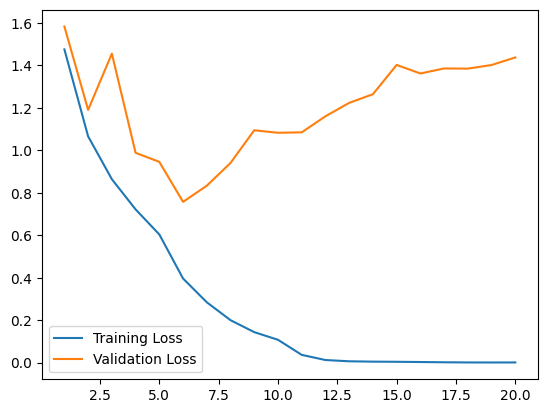

In [15]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), history.history['loss'], label='Training Loss')
plt.plot(np.arange(1, EPOCHS+1), history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

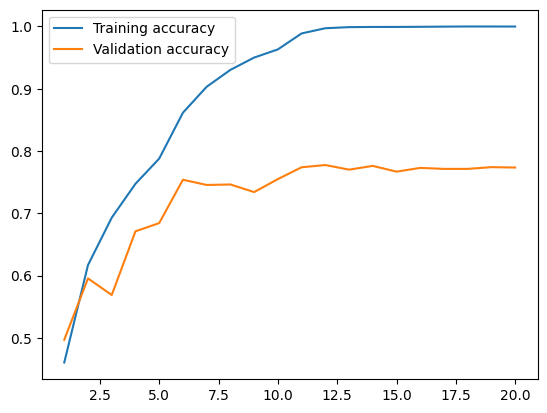

In [17]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), history.history['accuracy'], label='Training accuracy')
plt.plot(np.arange(1, EPOCHS+1), history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

## Overfitting!

- How can we alleviate overfitting problem?
    - Dropout might help.

In [18]:
from tensorflow.keras.layers import SpatialDropout2D

In [19]:
def make_simple_ResNet_dropout(input_shape, channels, block:str, num_classes:int, dropout_rate):

    input_tensor=Input(input_shape)
    x = Conv2D(filters=channels[0], kernel_size=(3,3), padding='same',
               activation=None, use_bias=False, kernel_initializer='he_uniform')(input_tensor)
    x = BatchNormalization()(x)
    x = relu(x)

    if block=='basic':
        x = BasicBlock(channels[0], stride=1)(x)
        x = BasicBlock(channels[1], stride=2)(x)
        x = SpatialDropout2D(rate=dropout_rate)(x)
        x = BasicBlock(channels[2], stride=2)(x)
        x = SpatialDropout2D(rate=dropout_rate)(x)
        x = BasicBlock(channels[3], stride=2)(x)
        x = SpatialDropout2D(rate=dropout_rate)(x)
        x = BasicBlock(channels[4], stride=2)(x)

    elif block == 'bottleneck':
        x = BottleneckBlock(channels[0], stride=1)(x)
        x = BottleneckBlock(channels[1], stride=2)(x)
        x = SpatialDropout2D(rate=dropout_rate)(x)
        x = BottleneckBlock(channels[2], stride=2)(x)
        x = SpatialDropout2D(rate=dropout_rate)(x)
        x = BottleneckBlock(channels[3], stride=2)(x)
        x = SpatialDropout2D(rate=dropout_rate)(x)
        x = BottleneckBlock(channels[4], stride=2)(x)

    else:
        raise ValueError

    x = GlobalAveragePooling2D()(x)

    x = Dense(channels[4]//4, activation=None, use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=x)

    return model

In [20]:
basic_model_dropout = make_simple_ResNet_dropout(input_shape=trainX.shape[1:], channels=[16,32,64,128,256],
                                                 block='basic', num_classes=n_classes, dropout_rate=0.5)

optimizer = Adam()
basic_model_dropout.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [22]:
basic_model_dropout.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 32, 32, 16)   432         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 32, 32, 16)  64          ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf.nn.relu_12 (TFOpLambda)     (None, 32, 32, 16)   0           ['batch_normalization_12[0]

In [23]:
from tensorflow.keras.callbacks import LearningRateScheduler

EPOCHS=20
LR = LearningRateScheduler(lambda epoch: 0.01*(0.5**int(epoch//5))*(0.97 ** epoch), verbose=1)

history2=basic_model_dropout.fit(trainX, trainY, batch_size=128, epochs=EPOCHS, validation_data=(validX, validY), callbacks=[LR])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/20
352/352 [==============================] - 18s 24ms/step - loss: 1.9709 - accuracy: 0.2421 - val_loss: 1.7764 - val_accuracy: 0.3142 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.0097.
Epoch 2/20
352/352 [==============================] - 8s 23ms/step - loss: 1.6519 - accuracy: 0.3833 - val_loss: 1.8238 - val_accuracy: 0.3510 - lr: 0.0097

Epoch 3: LearningRateScheduler setting learning rate to 0.009408999999999999.
Epoch 3/20
352/352 [==============================] - 8s 23ms/step - loss: 1.5003 - accuracy: 0.4485 - val_loss: 1.4890 - val_accuracy: 0.4566 - lr: 0.0094

Epoch 4: LearningRateScheduler setting learning rate to 0.00912673.
Epoch 4/20
352/352 [==============================] - 8s 22ms/step - loss: 1.3922 - accuracy: 0.4905 - val_loss: 1.3910 - val_accuracy: 0.5070 - lr: 0.0091

Epoch 5: LearningRateScheduler setting learning rate to 0.008852928099999999.
Epoch 5/20
352/352 [

In [24]:
test_loss, test_acc = basic_model_dropout.evaluate(testX, testY, verbose=1)

313/313 [==============================] - 1s 5ms/step - loss: 0.9501 - accuracy: 0.6675


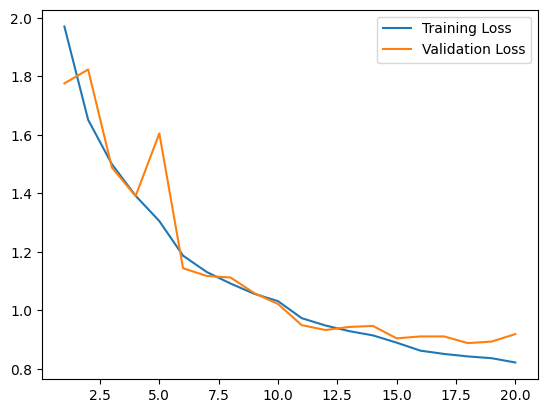

In [25]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), history2.history['loss'], label='Training Loss')
plt.plot(np.arange(1, EPOCHS+1), history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

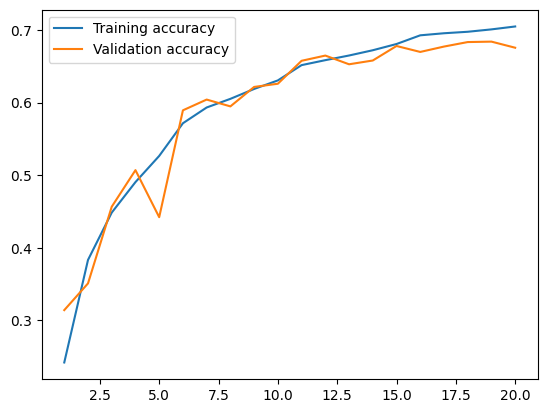

In [26]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), history2.history['accuracy'], label='Training accuracy')
plt.plot(np.arange(1, EPOCHS+1), history2.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

### Why did the test accuracy decrease? Is it natural?
